In [1]:
import matplotlib.pyplot as plt

import os
import numpy as np

from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
import pandas as pd

import tensorflow.keras as keras
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.applications.vgg16 import VGG16
import pickle
import tensorflow as tf


In [2]:
print(tf.__version__)

2.5.0-dev20201228


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
data = pd.read_csv('/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train.csv')
data['label'] = data['label'].astype('str')
data.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [3]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    shear_range=20,
    zoom_range=0.2,
    height_shift_range=0.1,
    width_shift_range=0.1,
    validation_split=0.2
)

In [4]:
img_size = (56,56)
batch = 6
train_imagegen = train_datagen.flow_from_dataframe(
    data,
    directory='/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/train_images/',
    x_col='image_id',
    y_col='label',
    subset='training',
    target_size= img_size,
    class_mode='raw',
    batch_size=batch
)

Found 17118 validated image filenames.


In [4]:
def save_all_features(nb_samples, source = '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava', dest="features", input_size = (416, 416), batch_size=6):
    
    # check if the directory exists, and if not make it
    if not os.path.exists(dest):
        os.makedirs(dest)
    
    # define image height and width
    (img_height, img_width) = input_size
    
    # build the VGG16 network and extract features after every MaxPool layer
    model = VGG16(weights='imagenet', include_top=False)
    
    c1 = model.layers[-16].output 
    c1 = GlobalAveragePooling2D()(c1)       

    c2 = model.layers[-13].output
    c2 = GlobalAveragePooling2D()(c2)       

    c3 = model.layers[-9].output
    c3 = GlobalAveragePooling2D()(c3)       

    c4 = model.layers[-5].output
    c4 = GlobalAveragePooling2D()(c4)       

    c5 = model.layers[-1].output
    c5 = GlobalAveragePooling2D()(c5)       

    model = Model(inputs=model.input, outputs=(c1,c2,c3,c4,c5))
    
    data = pd.read_csv(source + '/train.csv')
    data['label'] = data['label'].astype('str')
    
    train_datagen = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=20,
    shear_range=20,
    zoom_range=0.2,
    height_shift_range=0.1,
    width_shift_range=0.1,
    validation_split=0.2
    )
    
    train_imagegen = train_datagen.flow_from_dataframe(
    data,
    directory = source + '/train_images/',
    x_col='image_id',
    y_col='label',
    subset='training',
    target_size= input_size,
    class_mode='raw',
    batch_size=batch_size
    )
    
    # generate and save features, labels and respective filenames
    steps = nb_samples/batch_size+1
    X = model.predict(train_imagegen, steps)
    Y = np.concatenate([train_imagegen.next()[1] for i in range(0, train_imagegen.samples, batch_size)])
    names = train_imagegen.filenames

    for n, i in enumerate(X):
        with open(dest+"X-"+str(img_height)+"-c"+str(n+1)+"-AVG.npy", 'wb') as f:
                np.save(f, i)
    if not os.path.exists(dest+"Y.npy"):
        with open(dest+"Y.npy"  , 'wb') as f:
            np.save(f, Y)
    if not os.path.exists(dest+"filenames.npy"):
        with open(dest+"filenames.npy"  , 'wb') as f:
            np.save(f, names)

In [3]:
def kfoldSVM_on_features(X, Y, modelname='0'):
    # define 10-fold cross validation test harness
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=555)
    cvscores, splits = [],[]

    for train, test in kfold.split(X, Y):
        clf = LinearSVC(C=1, loss='squared_hinge', penalty='l2', multi_class='ovr', max_iter=80000)
        clf.fit(X[train], Y[train])
        y_pred = clf.predict(X[test])
        acc = accuracy_score(Y[test],y_pred)*100
        cvscores.append(acc)
        splits.append((Y[test], y_pred))

        filename = ('/media/sergio/traballos sergio/msi/models/cassava/finalized_model_' + str(modelname) + '.sav')
        pickle.dump(clf, open(filename, 'wb'))
    print("Accuracy score averaged across 10 kfolds %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    return np.mean(cvscores), np.std(cvscores)

In [6]:
def evaluate(dest="features", size=512, strategy = "-AVG"):
    #
    size = str(size)
    l1 = np.load(dest+"X-"+size+"-c1"+strategy+".npy")
    l2 = np.load(dest+"X-"+size+"-c2"+strategy+".npy")
    l3 = np.load(dest+"X-"+size+"-c3"+strategy+".npy")
    l4 = np.load(dest+"X-"+size+"-c4"+strategy+".npy")
    l5 = np.load(dest+"X-"+size+"-c5"+strategy+".npy")
    a_all = np.concatenate([l1,l2,l3,l4,l5], 1)
    
    X = [l1, l2, l3, l4, l5, a_all]
    
    Y = np.load(dest +"Y.npy", allow_pickle = True)
    acc_no_norm = []
    acc_norm = []
    for n, x in enumerate(X):
        print
        if n==5:
            print('fused features across all conv blocks')
        else:
            print('conv block', n+1 )
        print('without normalization')
        print(x.shape)
        acc_no_norm.append(kfoldSVM_on_features(x, Y, modelname=str(n)+'without'))
        print("with square root normalization")
        x = np.sqrt(np.abs(x)) * np.sign(x)
        acc_norm.append(kfoldSVM_on_features(x, Y, modelname=str(n)+'with'))
    
    return acc_no_norm, acc_norm

In [2]:
input_size = (512,512)
nb_samples = 17118

In [5]:

save_all_features(nb_samples, source= '/media/sergio/traballos sergio/msi/datasets/kaggle/cassava' , dest="/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/feature-transfer/", input_size=input_size, batch_size=5)

print()
print("evaluating dataset with input size", input_size, "and GlobalAveragePooling2D")

Found 17118 validated image filenames.

evaluating dataset with input size (512, 512) and GlobalAveragePooling2D


In [ ]:
with tf.device('/gpu:0'):
    acc_no_norm, acc_norm = evaluate(dest="/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/feature-transfer/", size=input_size[0])

conv block 1
without normalization
(17118, 64)
['4' '4' '4' ... '3' '3' '2']


/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Accuracy score averaged across 10 kfolds 43.84% (+/- 18.31%)
with square root normalization
['4' '4' '4' ... '3' '3' '2']


/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Accuracy score averaged across 10 kfolds 37.31% (+/- 18.26%)
conv block 2
without normalization
(17118, 128)
['4' '4' '4' ... '3' '3' '2']


/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Accuracy score averaged across 10 kfolds 40.51% (+/- 21.05%)
with square root normalization
['4' '4' '4' ... '3' '3' '2']


/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Accuracy score averaged across 10 kfolds 32.79% (+/- 20.18%)
conv block 3
without normalization
(17118, 256)
['4' '4' '4' ... '3' '3' '2']


/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Accuracy score averaged across 10 kfolds 34.77% (+/- 20.28%)
with square root normalization
['4' '4' '4' ... '3' '3' '2']


/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Accuracy score averaged across 10 kfolds 31.29% (+/- 18.14%)
conv block 4
without normalization
(17118, 512)
['4' '4' '4' ... '3' '3' '2']


/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Accuracy score averaged across 10 kfolds 42.00% (+/- 19.18%)
with square root normalization
['4' '4' '4' ... '3' '3' '2']


In [ ]:
acc_no_norm_value = np.zeros((len(acc_no_norm)))
acc_norm_value = np.zeros((len(np.zeros((len(acc_no_norm))))))
for i in range(len(acc_no_norm)):
  acc_no_norm_value[i] = acc_no_norm[i][0]
for i in range(len(acc_norm)):
  acc_norm_value[i] = acc_norm[i][0]

print(acc_no_norm_value)
print(acc_norm_value)

In [ ]:

f = plt.figure()
f.set_size_inches(10.5, 8.5)
ax = f.add_subplot(111)
ax.yaxis.tick_right()
plt.plot(np.arange(1,len(acc_no_norm)+1,1), acc_no_norm_value, label='no norm')
plt.plot(np.arange(1,len(acc_norm)+1,1), acc_norm_value, label = 'norm')
plt.xlabel('feature point (6 = all)', fontsize = 18)
plt.ylabel('accuracy', fontsize = 18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
plt.legend(fontsize=19, loc = 'lower right')

(1, 260, 367, 3)


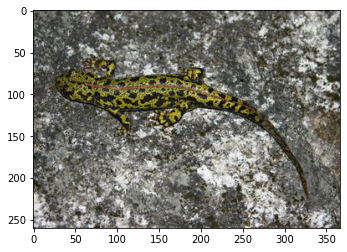

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = '/content/datos/datos_reducido/val/Triturus marmoratus/https3A2F2Fobservation.org2Fphotos2F1414769.jpg'
# Open the image form working directory
image = Image.open(image_path)
data = np.asarray(image)
y = np.expand_dims(data, axis=0)
print(y.shape)
imgplot = plt.imshow(data)

# Train 1 SVM

In [17]:
input_size = (512,512)
nb_samples = 17118

def kfoldSVM_on_features(X, Y, modelname='0'):
    # define 10-fold cross validation test harness
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=555)
    cvscores, splits = [],[]

    for train, test in kfold.split(X, Y):
        clf = LinearSVC(C=1, loss='squared_hinge', penalty='l2', multi_class='ovr', max_iter=8000)
        clf.fit(X[train], Y[train])
        y_pred = clf.predict(X[test])
        acc = accuracy_score(Y[test],y_pred)*100
        cvscores.append(acc)
        splits.append((Y[test], y_pred))

        filename = ('/media/sergio/traballos sergio/msi/models/cassava/finalized_model_' + str(modelname) + '.sav')
        pickle.dump(clf, open(filename, 'wb'))
    print("Accuracy score averaged across 10 kfolds %.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))
    return np.mean(cvscores), np.std(cvscores)

def evaluate(dest="features", size=512, strategy = "-AVG"):
    #
    size = str(size)
    l1 = np.load(dest+"X-"+size+"-c1"+strategy+".npy")
    l2 = np.load(dest+"X-"+size+"-c2"+strategy+".npy")
    l3 = np.load(dest+"X-"+size+"-c3"+strategy+".npy")
    l4 = np.load(dest+"X-"+size+"-c4"+strategy+".npy")
    l5 = np.load(dest+"X-"+size+"-c5"+strategy+".npy")
    a_all = np.concatenate([l1,l2,l3,l4,l5], 1)
    
    #X = [l1, l2, l3, l4, l5, a_all]
    X = l5
    n=4
    Y = np.load(dest +"Y.npy", allow_pickle = True)
    acc_no_norm = []
    acc_norm = []
    print('conv block', n+1 )
    print('without normalization')
    print(X.shape)
    acc_no_norm.append(kfoldSVM_on_features(X, Y, modelname=str(n)+'without'))
        #print("with square root normalization")
        #x = np.sqrt(np.abs(x)) * np.sign(x)
        #acc_norm.append(kfoldSVM_on_features(x, Y, modelname=str(n)+'with'))
    
    return acc_no_norm#, acc_norm

In [18]:
with tf.device('/gpu:0'):
    acc = evaluate(dest="/media/sergio/traballos sergio/msi/datasets/kaggle/cassava/feature-transfer/", size=input_size[0])

conv block 5
without normalization
(17118, 512)


/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase

Accuracy score averaged across 10 kfolds 54.10% (+/- 7.00%)


/home/sergio/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [8]:
model = VGG16(weights='imagenet', include_top=False)
c1 = model.layers[-16].output 
c1 = GlobalAveragePooling2D()(c1)       
c2 = model.layers[-13].output
c2 = GlobalAveragePooling2D()(c2)       
c3 = model.layers[-9].output
c3 = GlobalAveragePooling2D()(c3)       
c4 = model.layers[-5].output
c4 = GlobalAveragePooling2D()(c4)       
c5 = model.layers[-1].output
c5 = GlobalAveragePooling2D()(c5)  
model = Model(inputs=model.input, outputs=(c1,c2,c3,c4,c5))
X = model.predict(y)

a_all = np.concatenate([X[0],X[1],X[2],X[3],X[4]], 1)



filename = '/content/finalized_model_5without.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.predict(a_all)
print(result)

NameError: name 'y' is not defined

In [ ]:
a = np.load("/content/features/Y.npy")
b = np.load("/content/features/X-400-c1-AVG.npy")
c = np.load("/content/features/X-400-c2-AVG.npy")
files = np.load("/content/features/filenames.npy")

In [ ]:
print(a.shape)
print(b.shape)
print(c.shape)
print(files.shape)

(1101,)
(1001, 64)
(1001, 128)
(1101,)
